# OCC CMIP6 wave spectra analysis

---

## Introduction

This comprehensive guide demonstrates ocean wave spectra analysis using the Oceanum CMIP6 wave model outputs. The analysis leverages the powerful `wavespectra` Python library and [Datamesh](https://oceanum.io/) platform to provide insights into Global and New Zealand wave climate through high-resolution frequency-direction spectral information.

**Key Features:**
- Access to 400+ years of CMIP6 wave model data
- Global WAVEWATCH III and New Zealand SWAN model outputs
- Spectra processing and analysis
- Climate scenario comparisons (Historical, SSP2-4.5, SSP3-7.0)
- Boundary condition generation for nested wave models

## Background

### Wave Model Setup

The Oceanum CMIP6 wave modeling suite consists of two nested components:

#### Global Component: WAVEWATCH III Model
- **Resolution**: 1-degree (~100 km)
- **Coverage**: Global ocean domains
- **Forcing**: Direct CMIP6 atmospheric outputs

#### Regional Component: SWAN Model
- **Resolution**: 0.05-degree (~5 km)
- **Coverage**: New Zealand waters and surrounding regions
- **Forcing**: NIWA's 5-km downscaled atmospheric data

This nested approach ensures both global consistency and regional accuracy, critical for understanding wave climate around New Zealand's complex coastline and diverse bathymetry.

### Climate Model Forcing

Two CMIP6 global climate models drive the wave simulations:

* **ACCESS-CM2** (CSIRO, Australia)
* **EC-Earth3** (European Consortium)

The integration of these models provides ensemble-based uncertainty quantification and robust climate projections.

### Temporal Coverage and Climate Scenarios

The dataset provides **400 years** of continuous wave model output for each model suite:

#### Historical Period (1985-2015)
- **Duration**: 30 years
- **Purpose**: Baseline climate conditions
- **Description**: Observed climate conditions
- **Applications**: Model skill assessment and bias correction

#### SSP2-4.5 Scenario (2015-2100)
- **Duration**: 85 years
- **Emission Level**: Moderate (Representative Concentration Pathway ~4.5 W/m²)
- **Description**: Sustainable development pathway
- **Applications**: Mid-range climate impact assessments

#### SSP3-7.0 Scenario (2015-2100)
- **Duration**: 85 years
- **Emission Level**: High (Representative Concentration Pathway ~7.0 W/m²)
- **Description**: Regional rivalry pathway
- **Applications**: High-end climate risk assessments

**Temporal Resolution**: All data are output at 3-hourly intervals, providing detailed temporal resolution

### Data Product Portfolio

The Oceanum CMIP6 suite offers three complementary datasets:

#### 1. Gridded Wave Parameters
- **Content**: 28 wave and forcing parameters
- **Processing**: Integrated over full spectrum and spectral partitions
- **Parameters Include**:
  - Significant wave height (Hs)
  - Peak and mean periods (Tp, Tm01, Tm02)
  - Wave directions and spreading
  - Wind sea and swell partitions
  - Wind vectors, depth, sea ice concentration

#### 2. Wave Spectra (Focus of This Analysis)
- **Content**: Frequency-direction wave spectra $E(f,θ)$
- **Locations**: 4,000+ global points, 1,321 around New Zealand
- **Resolution**: Enhanced near coasts and shallow areas
- **Applications**: Detailed spectral analysis, model validation, boundary conditions

#### 3. Gridded Wave Statistics
- **Content**: Pre-computed statistical measures
- **Statistics**: Means, maxima, quantiles (10th, 50th, 75th, 90th, 95th, 99th percentiles)
- **Variables**: Key wave parameters across all grid points
- **Applications**: Climate impact studies, design wave estimation

---

## Notebook Objectives

This analysis demonstrates the potential of wave spectra data in Datamesh through five comprehensive modules:

### Module 1: Data Access and Infrastructure
**Objectives:**
- Establish secure Datamesh connection with authentication
- Implement efficient data querying strategies
- Demonstrate metadata exploration techniques
- Set up reproducible analysis environment

### Module 2: Spectral Data Exploration
**Objectives:**
- Load and inspect wave spectra datasets
- Analyse spectral resolution and grid characteristics
- Visualise spectral output locations using mapping
- Compare coverage between global and regional domains

### Module 3: Spectral Analysis with wavespectra
**Objectives:**
- Calculate integrated wave parameters from 2D spectra
- Perform spectral transformations
- Extract directional spreading and frequency statistics
- Implement spectral partitioning algorithms

### Module 4: Spatial and Temporal Pattern Analysis
**Objectives:**
- Compare spectral characteristics in the Southern Ocean SW of New Zealand
- Analyse seasonal variations
- Assess climate model differences in spectral representation

### Module 5: Boundary Condition Applications
**Objectives:**
- Extract boundary spectra for nested wave modeling
- Generate SWAN and WAVEWATCH III compatible forcing files

---

### Required Python Libraries

- [oceanum](https://oceanum-python.readthedocs.io/en/latest/): Python client for accessing Datamesh
- [wavespectra](https://wavespectra.readthedocs.io/en/latest/): Python library for spectral wave analysis
- [numpy](https://numpy.org/doc/stable/): Numerical computing library
- [pandas](https://pandas.pydata.org/pandas-docs/stable/): Data analysis library
- [xarray](https://xarray.pydata.org/en/stable/): Data analysis library
- [matplotlib](https://matplotlib.org/stable/contents.html): Data visualisation library
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/): Geospatial data visualisation library
- [shapely](https://shapely.readthedocs.io/en/stable/): Geospatial data analysis library
- [geopandas](https://geopandas.org/en/stable/): Geospatial data analysis library

In [127]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import Point
from datetime import datetime
from typing import Literal
from oceanum.datamesh import Connector

import warnings
warnings.filterwarnings("ignore")

opt = xr.set_options(display_expand_data_vars=True)

## 1. Setting Up the Connection

The [Connector](https://oceanum-python.readthedocs.io/en/latest/classes/datamesh/oceanum.datamesh.Connector.html) class provides access to methods for querying data and metadata from Datamesh.

**Authentication**: You can provide your Datamesh token directly or set it as an environment variable `DATAMESH_TOKEN`.

In [215]:
conn = Connector(token=None)

Using datamesh API version 0
You are using version 1.0.8 of oceanum_python. A new version is available: 1.0.9. Please update your client to benefit from the latest features and updates.


## 2. Accessing the data

### 2.1. Searching from Datamesh

The `get_catalog` method allows you to search for datasets using keywords that match against dataset names, descriptions, and tags.

Here we will search the wave spectra datasources using specific tags associated with them.

In [3]:
cat = conn.get_catalog("tags:occ+cmip6+wave+spectra")

datasources = sorted([ds.id for ds in cat])
datasources

['oceanum_cmip6_swan_nz_access_cm2_historical_r1i1p1f1_spectra',
 'oceanum_cmip6_swan_nz_access_cm2_ssp245_r1i1p1f1_spectra',
 'oceanum_cmip6_swan_nz_access_cm2_ssp370_r1i1p1f1_spectra',
 'oceanum_cmip6_swan_nz_ec_earth3_historical_r1i1p1f1_spectra',
 'oceanum_cmip6_swan_nz_ec_earth3_ssp245_r1i1p1f1_spectra',
 'oceanum_cmip6_swan_nz_ec_earth3_ssp370_r1i1p1f1_spectra',
 'oceanum_cmip6_ww3_global_access_cm2_historical_r1i1p1f1_spectra',
 'oceanum_cmip6_ww3_global_access_cm2_ssp245_r1i1p1f1_spectra',
 'oceanum_cmip6_ww3_global_access_cm2_ssp370_r1i1p1f1_spectra',
 'oceanum_cmip6_ww3_global_ec_earth3_historical_r1i1p1f1_spectra',
 'oceanum_cmip6_ww3_global_ec_earth3_ssp245_r1i1p1f1_spectra',
 'oceanum_cmip6_ww3_global_ec_earth3_ssp370_r1i1p1f1_spectra']

### 2.2. Inspect datasource

Query a "lazy" view of one of the matching datasources using dask to inspect the data structure and content.

All wave spectra datasources follow the [wavespectra conventions](https://wavespectra.readthedocs.io/en/latest/conventions.html)
with frequency coordinates **freq** in $Hz$, direction **dir** in $degree$, and wave energy
density **efth** in $m^2/Hz$.

### 2.2.1. Global datasource

Query a lazy version of the global wave spectra dataset and inspect the spectral grid

In [4]:
dset_ww3 = conn.query(
    datasource="oceanum_cmip6_ww3_global_access_cm2_historical_r1i1p1f1_spectra",
    use_dask=True,
)
dset_ww3

<xarray.Dataset> Size: 2TB
Dimensions:  (dir: 24, time: 87657, site: 4128, freq: 31)
Coordinates:
  * dir      (dir) float32 96B 270.0 255.0 240.0 225.0 ... 315.0 300.0 285.0
  * freq     (freq) float32 124B 0.037 0.0407 0.04477 ... 0.5336 0.5869 0.6456
  * site     (site) float64 33kB 1.0 2.0 3.0 ... 4.126e+03 4.127e+03 4.128e+03
  * time     (time) datetime64[ns] 701kB 1985-01-01 ... 2015-01-01
Data variables:
    dpt      (time, site) float32 1GB dask.array<chunksize=(8192, 4), meta=np.ndarray>
    efth     (time, site, freq, dir) float64 2TB dask.array<chunksize=(8192, 4, 31, 24), meta=np.ndarray>
    lat      (site) float32 17kB dask.array<chunksize=(4128,), meta=np.ndarray>
    lon      (site) float32 17kB dask.array<chunksize=(4128,), meta=np.ndarray>
    wdir     (time, site) float32 1GB dask.array<chunksize=(8192, 4), meta=np.ndarray>
    wspd     (time, site) float32 1GB dask.array<chunksize=(8192, 4), meta=np.ndarray>

In [5]:
print(f"{dset_ww3.freq.size} Frequency bins:")

dset_ww3.freq.values

31 Frequency bins:


array([0.037     , 0.0407    , 0.04477   , 0.049247  , 0.0541717 ,
       0.05958887, 0.06554776, 0.07210253, 0.07931279, 0.08724407,
       0.09596848, 0.10556533, 0.11612187, 0.12773405, 0.14050746,
       0.15455821, 0.17001402, 0.18701543, 0.20571698, 0.22628868,
       0.24891755, 0.2738093 , 0.30119026, 0.3313093 , 0.3644402 ,
       0.40088424, 0.44097266, 0.48506996, 0.53357697, 0.5869347 ,
       0.64562815], dtype=float32)

In [6]:
print(f"{dset_ww3.dir.size} Direction bins:")

dset_ww3.dir.values

24 Direction bins:


array([270., 255., 240., 225., 210., 195., 180., 165., 150., 135., 120.,
       105.,  90.,  75.,  60.,  45.,  30.,  15.,   0., 345., 330., 315.,
       300., 285.], dtype=float32)

### 2.2.2. New Zealand datasource

Query a lazy version of the New Zealand wave spectra dataset and inspect the spectral grid

In [7]:
dset_swan = conn.query(
    datasource="oceanum_cmip6_swan_nz_access_cm2_historical_r1i1p1f1_spectra",
    use_dask=True,
)
dset_swan

<xarray.Dataset> Size: 1TB
Dimensions:  (dir: 36, time: 87657, site: 1321, freq: 32)
Coordinates:
  * dir      (dir) float32 144B 265.0 255.0 245.0 235.0 ... 295.0 285.0 275.0
  * freq     (freq) float32 128B 0.037 0.0407 0.04477 ... 0.5869 0.6456 0.7102
  * site     (site) int64 11kB 1 2 3 4 5 6 7 ... 1316 1317 1318 1319 1320 1321
  * time     (time) datetime64[ns] 701kB 1985-01-01 ... 2015-01-01
Data variables:
    dpt      (time, site) float32 463MB dask.array<chunksize=(8192, 4), meta=np.ndarray>
    efth     (time, site, freq, dir) float64 1TB dask.array<chunksize=(8192, 4, 32, 36), meta=np.ndarray>
    lat      (site) float32 5kB dask.array<chunksize=(1321,), meta=np.ndarray>
    lon      (site) float32 5kB dask.array<chunksize=(1321,), meta=np.ndarray>
    wdir     (time, site) float32 463MB dask.array<chunksize=(8192, 4), meta=np.ndarray>
    wspd     (time, site) float32 463MB dask.array<chunksize=(8192, 4), meta=np.ndarray>

In [8]:
print(f"{dset_swan.freq.size} Frequency bins:")

dset_swan.freq.values

32 Frequency bins:


array([0.037     , 0.0407    , 0.04477   , 0.049247  , 0.0541717 ,
       0.05958887, 0.06554776, 0.07210253, 0.07931279, 0.08724407,
       0.09596848, 0.10556533, 0.11612187, 0.12773405, 0.14050746,
       0.15455821, 0.17001402, 0.18701543, 0.20571698, 0.22628868,
       0.24891755, 0.2738093 , 0.30119026, 0.3313093 , 0.3644402 ,
       0.40088424, 0.4409727 , 0.48506996, 0.53357697, 0.5869347 ,
       0.64562815, 0.710191  ], dtype=float32)

In [9]:
print(f"{dset_swan.dir.size} Direction bins:")

dset_swan.dir.values

36 Direction bins:


array([265.      , 255.      , 245.00002 , 235.00002 , 225.      ,
       215.      , 205.      , 194.99998 , 185.      , 175.      ,
       165.      , 155.      , 145.      , 135.      , 124.99999 ,
       114.99999 , 104.99999 ,  94.99999 ,  85.      ,  74.999985,
        64.999985,  54.99999 ,  44.999992,  34.999992,  24.999996,
        14.999997,   4.999999, 354.99997 , 344.99997 , 334.99997 ,
       324.99997 , 314.99997 , 305.      , 295.      , 285.      ,
       275.      ], dtype=float32)

#### 2.2.3 Visualise spectral grid

Plot the spectral grids on a polar axis

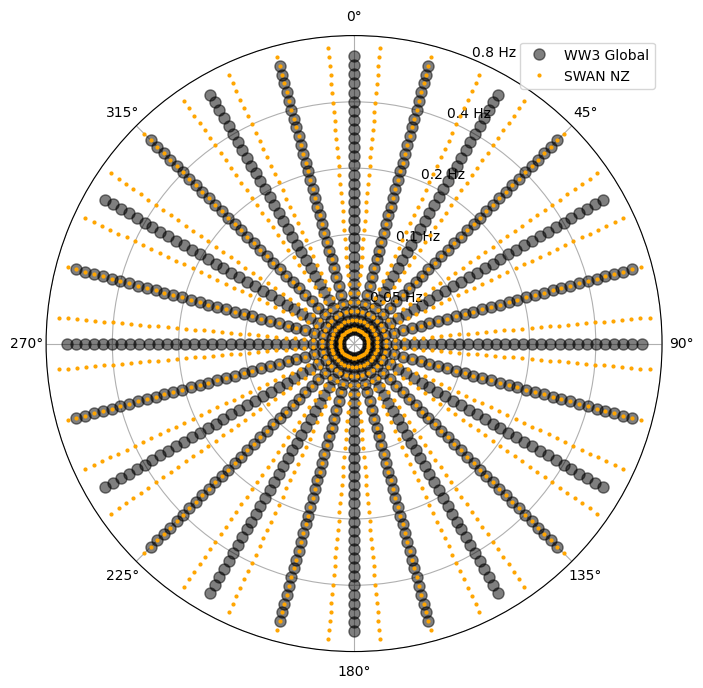

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw=dict(projection="polar"))

# WW3 Global
dd, ff = np.meshgrid(dset_ww3.dir, dset_ww3.freq)
dd = np.deg2rad(dd)
ax.plot(dd.ravel(), ff.ravel(), "ok", markersize=8, alpha=0.5, label="WW3 Global")

# SWAN New Zealand
dd, ff = np.meshgrid(dset_swan.dir, dset_swan.freq)
dd = np.deg2rad(dd)
ax.plot(dd.ravel(), ff.ravel(), "o", color="orange", markersize=2, label="SWAN NZ")

ax.legend()

ax.set_rscale("log")
ax.set_rlim(0, 0.8)  
freq_bands = [0.05, 0.1, 0.2, 0.4, 0.8]
ax.set_rgrids(freq_bands, labels=[f"{f} Hz" for f in freq_bands])

ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")
t = ax.set_thetagrids(np.arange(0, 360, 45))

### 2.3. Querying the data

The [query](https://oceanum-python.readthedocs.io/en/latest/classes/datamesh/oceanum.datamesh.Query.html#oceanum.datamesh.Query) method from the Oceanum Datamesh Connector is the most
efficient way to retrieve data from the Datamesh. The function allows you to subset the data
in time and space, and the processing is all done on the server side so the data transfer is
minimal. This allows us to access timeseries or spatial slices from very large (Terabytes)
datasets, in just a matter of seconds.

#### 2.3.1. Query the spatial coordinates

The **lon** and **lat** variables define the geographic locations where wave spectra are available in the dataset. These coordinate variables have only the **site** dimension, making them relatively small and efficient to load into memory for the entire dataset.

Here we load the **lon** and **lat** variables from representative datasources - one global and one New Zealand regional. Note that the spectral output locations remain consistent across all model versions and time periods within each domain (global vs regional).

In [11]:
coords_ww3 = conn.query(
    datasource="oceanum_cmip6_ww3_global_access_cm2_historical_r1i1p1f1_spectra",
    variables=["lon", "lat"],
)
coords_ww3

<xarray.Dataset> Size: 66kB
Dimensions:  (site: 4128)
Coordinates:
    lon      (site) float32 17kB 180.0 180.0 180.0 180.0 ... 165.0 165.0 165.0
    lat      (site) float32 17kB -60.0 -56.0 -52.0 -48.0 ... -45.0 -46.0 -47.0
  * site     (site) float64 33kB 1.0 2.0 3.0 ... 4.126e+03 4.127e+03 4.128e+03
Data variables:
    *empty*
Attributes: (12/19)
    altitude_resolution:    n/a
    area:                   Global 1 x 1 degree forced wit
    data_type:              OCO spectra 2D
    easternmost_longitude:  n/a
    field_type:             3-hourly
    format_version:         1.1
    ...                     ...
    start_date:             2014-01-01 00:00:00
    stop_date:              2015-01-01 00:00:00
    westernmost_longitude:  n/a
    _coordinates:           {"d":"dir","f":"freq","t":"time","x":"lon","y":"l...
    _request_size:          66048
    _domain_size:           4128

In [12]:
coords_swan = conn.query(
    datasource="oceanum_cmip6_swan_nz_access_cm2_historical_r1i1p1f1_spectra",
    variables=["lon", "lat"],
)
coords_swan

<xarray.Dataset> Size: 21kB
Dimensions:  (site: 1321)
Coordinates:
    lon      (site) float32 5kB 166.6 166.6 166.6 166.6 ... 179.4 179.8 179.8
    lat      (site) float32 5kB -40.0 -38.4 -36.8 -35.2 ... -35.2 -47.6 -47.2
  * site     (site) int64 11kB 1 2 3 4 5 6 7 ... 1316 1317 1318 1319 1320 1321
Data variables:
    *empty*
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    cycle:                   1985-01-01T00:00:00
    model:                   41.31A
    project:                 New Zealand 5km
    run:                     nz
    _coordinates:            {"d":"dir","f":"freq","t":"time","x":"lon","y":"...
    _request_size:           21136
    _domain_size:            1321

#### 2.3.2. Visualise the spectral locations

We will notice that there is a higher density of spectra output near the coast, and a lower density of spectra output further out to sea, where spatial gradients in wave spectra tend to be gentler.

##### 2.3.2.1. Global Spectra

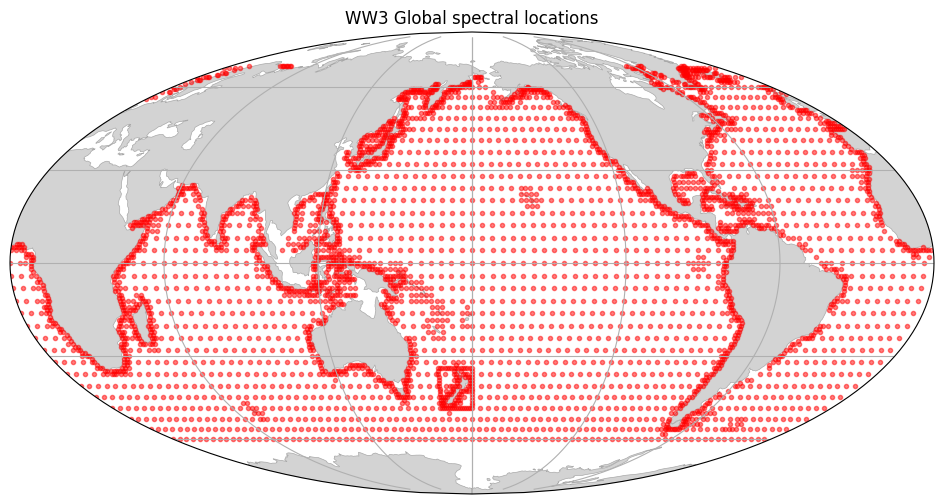

In [13]:
projection = ccrs.Mollweide(central_longitude=180)
transform = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(12, 6), subplot_kw={"projection": projection})

ax.plot(coords_ww3.lon, coords_ww3.lat, "or", markersize=3, alpha=0.5, transform=transform)
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="darkgray", linewidth=0.5)
ax.set_global()
ax.gridlines()
t = ax.set_title("WW3 Global spectral locations")

##### 2.3.2.2. New Zealand Spectra

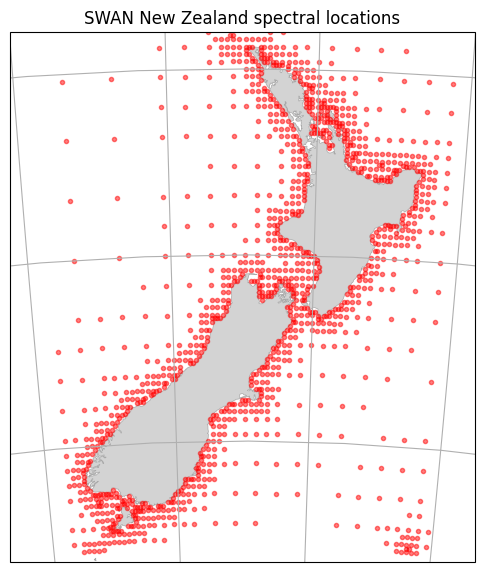

In [14]:
# Get the bounds from a SWAN gridded parameters datasource
ds = conn.get_datasource("oceanum_cmip6_swan_nz_access_cm2_historical_r1i1p1f1_grid")
x0, y0, x1, y1 = ds.geom.bounds

projection = ccrs.TransverseMercator(central_longitude=(x0 + x1) / 2)
transform = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(6, 8), subplot_kw={"projection": projection})

ax.plot(coords_swan.lon, coords_swan.lat, "or", markersize=3, alpha=0.5, transform=transform)
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="darkgray", linewidth=0.5)
ax.set_extent([x0, x1, y0, y1], crs=transform)
ax.gridlines(xlocs=[165, 170, 175, 180], ylocs=[-45, -40, -35])
t = ax.set_title("SWAN New Zealand spectral locations")

## 3. Spectral Analysis and Processing using wavespectra

The rich frequency-direction information in the Oceanum CMIP6 wave spectra dataset enables comprehensive spectral analysis beyond what's available from integrated parameters alone. Using the `wavespectra` Python library, we can:

- **Calculate derived parameters** not available in the gridded outputs (e.g., additional swell partition statistics, directional spreading coefficients)
- **Perform spectral transformations** such as frequency and directional interpolation
- **Extract detailed wave system characteristics** through advanced partitioning algorithms
- **Analyse spectral evolution** over time and space with full frequency-direction resolution

This detailed spectral information provides deeper insights into wave climate processes, particularly for understanding complex multi-modal sea states common in New Zealand waters where wind seas and multiple swell systems often coexist.

### 3.1. Spectra timeseries slicing

Slicing a timeseries from a spectra datasource can be done by defining a `geofilter` to
select one or more points, or an area bounded by a box or polygon.

Here, we are going to define a location on the West Coast of New Zealand,
and use it to slice the timeseries of wave spectra from the Oceanum CMIP6 wave model outputs.

In [15]:
west = Point(173.674604, -37.758241)

#### 3.1.1. Define a function to query timeseries at selected point locations.

In [60]:
def query_timeseries(
    datasource: str,
    points: list,
    t0: str = None,
    t1: str = None,
    interp: Literal["linear", "nearest"] = "nearest",
) -> xr.Dataset:
    """Query wave spectra timeseries from Oceanum Datamesh at selected points.

    Parameters
    ----------
    datasource : str
        The name of the datasource to query.
    points: list[Point]
        The points to query at.
    t0 : str, optional
        The start time of the query. Defaults to None which implies the start of the dataset.
    t1 : str, optional
        The end time of the query. Defaults to None which implies the end of the dataset.
    interp : Literal["linear", "nearest"], optional
        The interpolation method to use. Defaults to "nearest".

    Returns
    -------
    timeseries : xr.Dataset
        The timeseries dataset.

    """
    query = {
        "datasource": datasource,
        "timefilter": {"type": "range", "times": [t0, t1]},
        "geofilter": {
            "type": "feature",
            "interp": interp,
            "geom": {
                "type": "Feature",
                "geometry": {
                    "type": "MultiPoint",
                    "coordinates": [[point.x, point.y] for point in points],
                },
            },
        },
    }
    print(query)
    return conn.query(query).squeeze().reset_coords()

#### 3.1.2. Query spectra timeseries data from a model

Select 1-year of data from the SWAN EC-Earth3 historical spectra datasource to work with

In [17]:
dset_spectra = query_timeseries(
    datasource="oceanum_cmip6_swan_nz_ec_earth3_historical_r1i1p1f1_spectra",
    points=[west],
    t0="2010-01-01T00:00:00",
    t1="2011-01-01T00:00:00",
)
dset_spectra

<xarray.Dataset> Size: 27MB
Dimensions:      (dir: 36, time: 2921, freq: 32)
Coordinates:
  * dir          (dir) float32 144B 265.0 255.0 245.0 ... 295.0 285.0 275.0
  * freq         (freq) float32 128B 0.037 0.0407 0.04477 ... 0.6456 0.7102
  * time         (time) datetime64[ns] 23kB 2010-01-01 ... 2011-01-01
Data variables:
    dpt          (time) float32 12kB 957.3 957.3 957.3 ... 957.3 957.3 957.3
    efth         (time, freq, dir) float64 27MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lat          float32 4B -37.6
    lon          float32 4B 173.8
    site         int64 8B 721
    wdir         (time) float32 12kB 207.6 220.8 220.2 ... 61.0 329.0 352.5
    wspd         (time) float32 12kB 4.625 6.356 5.758 6.35 ... 2.89 2.525 2.528
    spatial_ref  int64 8B 0
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    cycle:                   1985-01-01T00:00:00
    model:                   41.31A
    project:                 New Zealand 5km
    run:                     nz
    xinterp_method:          nearest
    _coordinates:            {"d":"dir","f":"freq","t":"time","x":"lon","y":"...
    _request_size:           26978652

### 3.2. Integrated parameters

#### 3.2.1. Calculate timeseries of integrated parameters

Calculate integrated parameters from the full spectrum over the 1-year period at the selected location.

In [18]:
ds = dset_spectra.spec.stats(["hs", "tp", "tm01", "tm02", "dpm", "dspr", "sw"])
ds

<xarray.Dataset> Size: 164kB
Dimensions:  (time: 2921)
Coordinates:
  * time     (time) datetime64[ns] 23kB 2010-01-01 ... 2011-01-01
Data variables:
    hs       (time) float64 23kB 1.219 1.189 1.15 1.109 ... 1.305 1.215 1.141
    tp       (time) float32 12kB dask.array<chunksize=(2921,), meta=np.ndarray>
    tm01     (time) float64 23kB 6.801 6.591 6.282 5.892 ... 10.97 10.86 10.65
    tm02     (time) float64 23kB 5.436 5.257 5.036 4.759 ... 10.14 10.16 9.935
    dpm      (time) float32 12kB dask.array<chunksize=(2921,), meta=np.ndarray>
    dspr     (time) float64 23kB 28.84 28.06 27.52 27.36 ... 14.22 15.21 16.57
    sw       (time) float64 23kB 0.7518 0.7563 0.7457 ... 0.4133 0.3778 0.3859
Attributes:
    standard_name:  sea_surface_wave_significant_height
    units:          m

#### 3.2.2. Plotting the timeseries

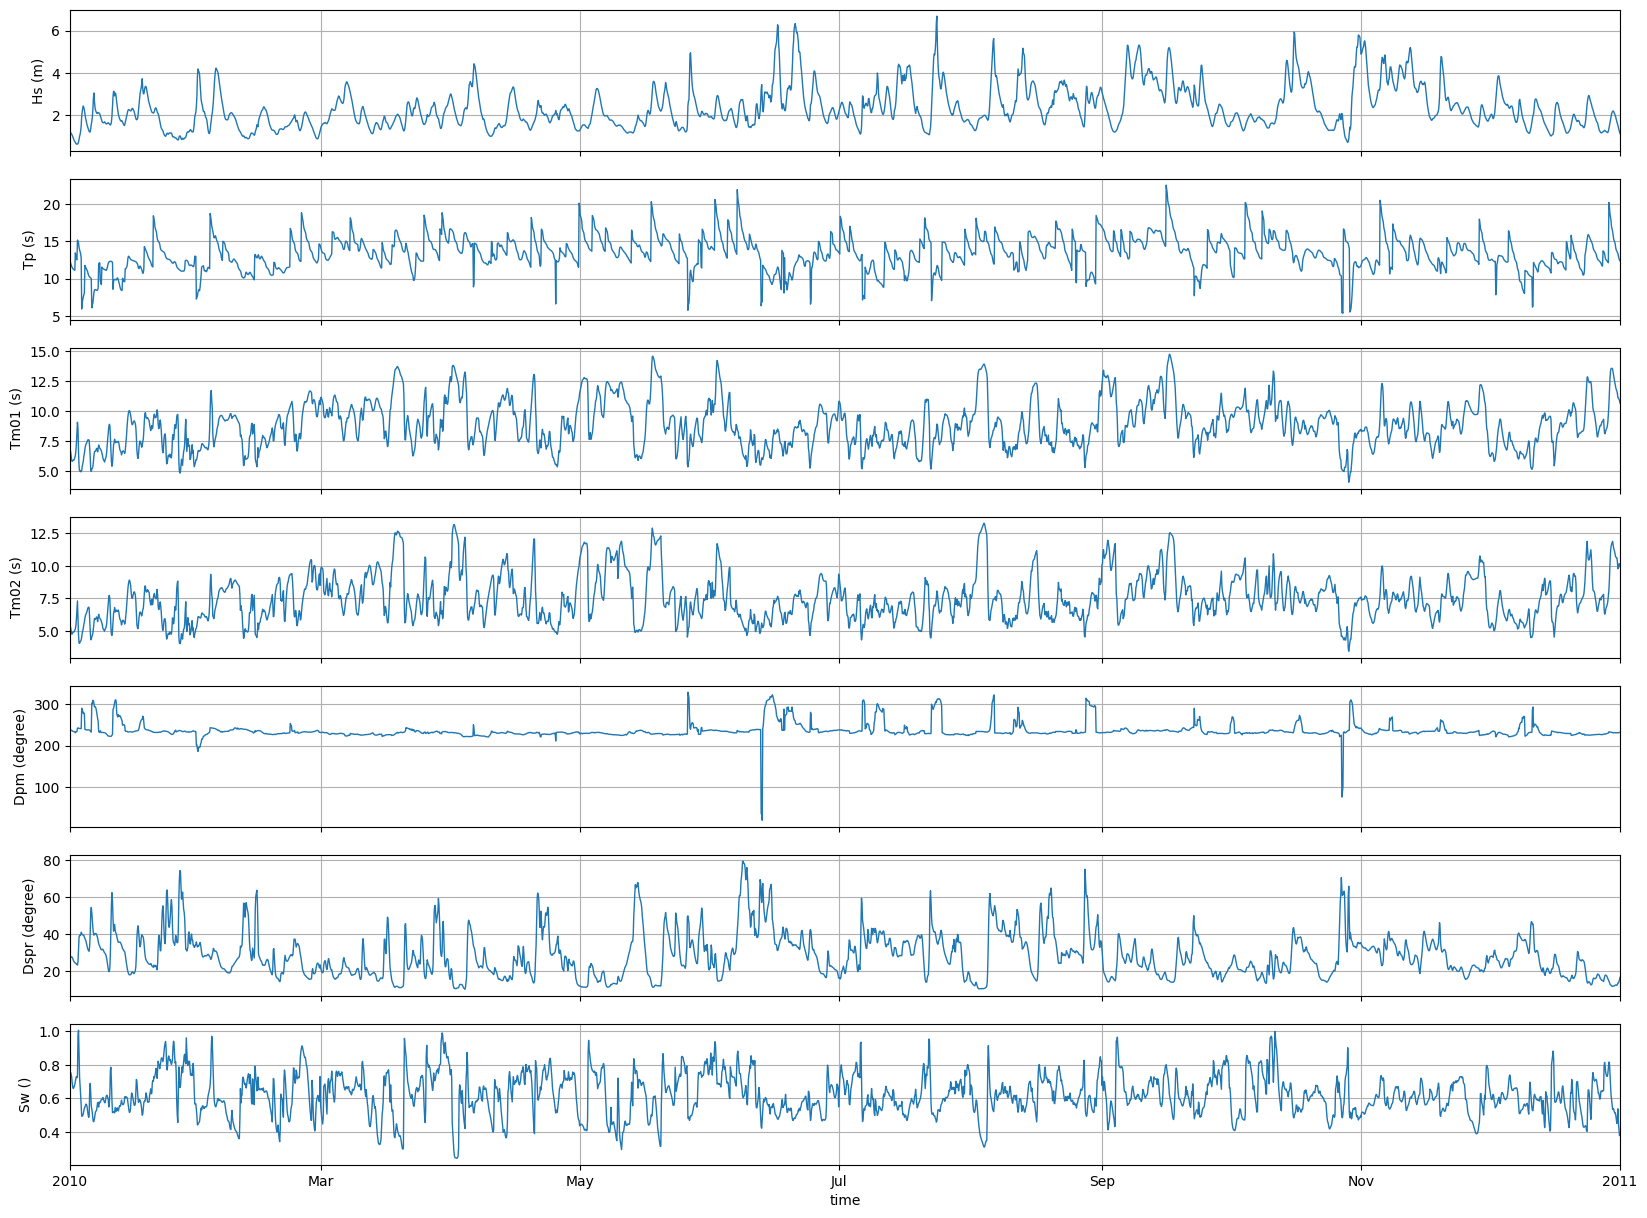

In [19]:
fig, axs = plt.subplots(7, 1, figsize=(20, 15))

for ind, da in enumerate(ds.data_vars.values()):
    ax = axs[ind]
    da.plot(ax=ax, linewidth=1.0)
    ax.set_ylabel(f"{da.name.title()} ({da.units})")

for ind, ax in enumerate(axs):
    if ind < len(axs) - 1:
        ax.set_xticklabels("")
        ax.set_xlabel("")
    ax.grid()
    ax.set_xlim(ds.time.to_index()[[0, -1]])

#### 3.2.3. Calculate summary Hs stats

Convert the 1-year timeseries to pandas and calculate some summary stats

In [20]:
ds.hs.to_pandas().describe()

count    2921.000000
mean        2.359362
std         0.995527
min         0.637348
25%         1.641109
50%         2.112648
75%         2.858117
max         6.679460
Name: hs, dtype: float64

### 3.3. Wave partitioning

Partition and analyse the spectra using different techniques

#### 3.3.1. Frequency split

The [split](https://wavespectra.readthedocs.io/en/latest/generated/wavespectra.SpecArray.split.html#wavespectra-specarray-split) method from wavespectra can be used to split the spectra into "sea" and "swell"
components based on a user-defined frequency threshold.

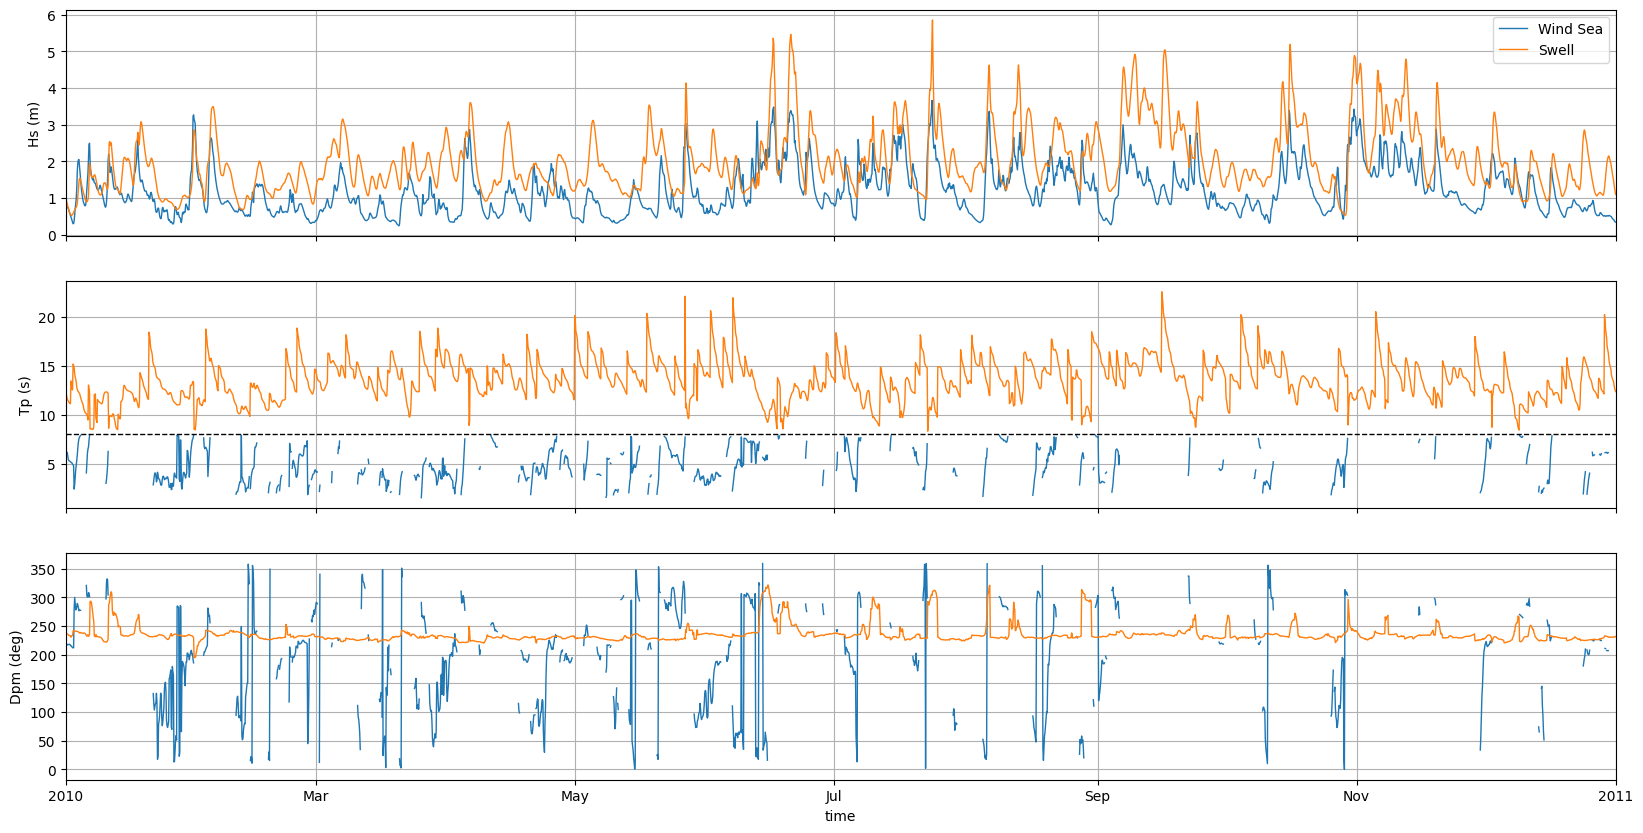

In [21]:
# Split the spectra into sea and swell components
fcut = 1 / 8
ds_sea8 = dset_spectra.spec.split(fmin=fcut)
ds_swell8 = dset_spectra.spec.split(fmax=fcut)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(20, 10))

t0, t1 = dset_spectra.time.to_index()[[0, -1]]

# Calculate and plot Hs
ax = axs[0]
ds_sea8.spec.hs().plot(ax=ax, linewidth=1.0, label="Wind Sea")
ds_swell8.spec.hs().plot(ax=ax, linewidth=1.0, label="Swell")
ax.set_ylabel("Hs (m)")
l = ax.legend()

# Calculate and plot Tp
ax = axs[1]
ds_sea8.spec.tp().plot(ax=ax, linewidth=1.0, label="Wind Sea")
ds_swell8.spec.tp().plot(ax=ax, linewidth=1.0, label="Swell")
ax.plot([t0, t1], [8, 8], "k--", linewidth=1.0)
ax.set_ylabel("Tp (s)")

# Calculate and plot Dpm
ax = axs[2]
ds_sea8.spec.dpm().plot(ax=ax, linewidth=1.0, label="Wind Sea")
ds_swell8.spec.dpm().plot(ax=ax, linewidth=1.0, label="Swell")
ax.set_ylabel("Dpm (deg)")


for ind, ax in enumerate(axs):
    if ind < len(axs) - 1:
        ax.set_xticklabels("")
        ax.set_xlabel("")
    ax.grid()
    ax.set_xlim(t0, t1)

### 3.3.2. Watershed

Several other partitioning methods are available within the **partition** namespace of wavespectra.
Here we will use the [PTM1](https://wavespectra.readthedocs.io/en/latest/partitioning.html#ptm1)
partitioning method based on the watershed algorithm, also implemented in WW3 and SWAN models.

In [22]:
dspart = dset_spectra.spec.partition.ptm1(
    wspd=dset_spectra.wspd,
    wdir=dset_spectra.wdir,
    dpt=dset_spectra.dpt,
    agefac=1.7,
    swells=3
)

# The output is a DataArray, convert to Dataset just for better display
dspart.to_dataset()

<xarray.Dataset> Size: 54MB
Dimensions:  (dir: 36, freq: 32, time: 2921, part: 4)
Coordinates:
  * dir      (dir) float32 144B 265.0 255.0 245.0 235.0 ... 295.0 285.0 275.0
  * freq     (freq) float32 128B 0.037 0.0407 0.04477 ... 0.5869 0.6456 0.7102
  * time     (time) datetime64[ns] 23kB 2010-01-01 ... 2011-01-01
  * part     (part) int64 32B 0 1 2 3
Data variables:
    efth     (part, time, freq, dir) float32 54MB 0.0 0.0 0.0 ... 0.0 0.0 0.0

The output of the partitioning method is a new xarray wavespectra object with an extra
dimension **part** which holds the spectra for each partition. The 0th index holds the
wind sea partition, the following indices hold the swell partitions sorted in increasing
order of wave energy.

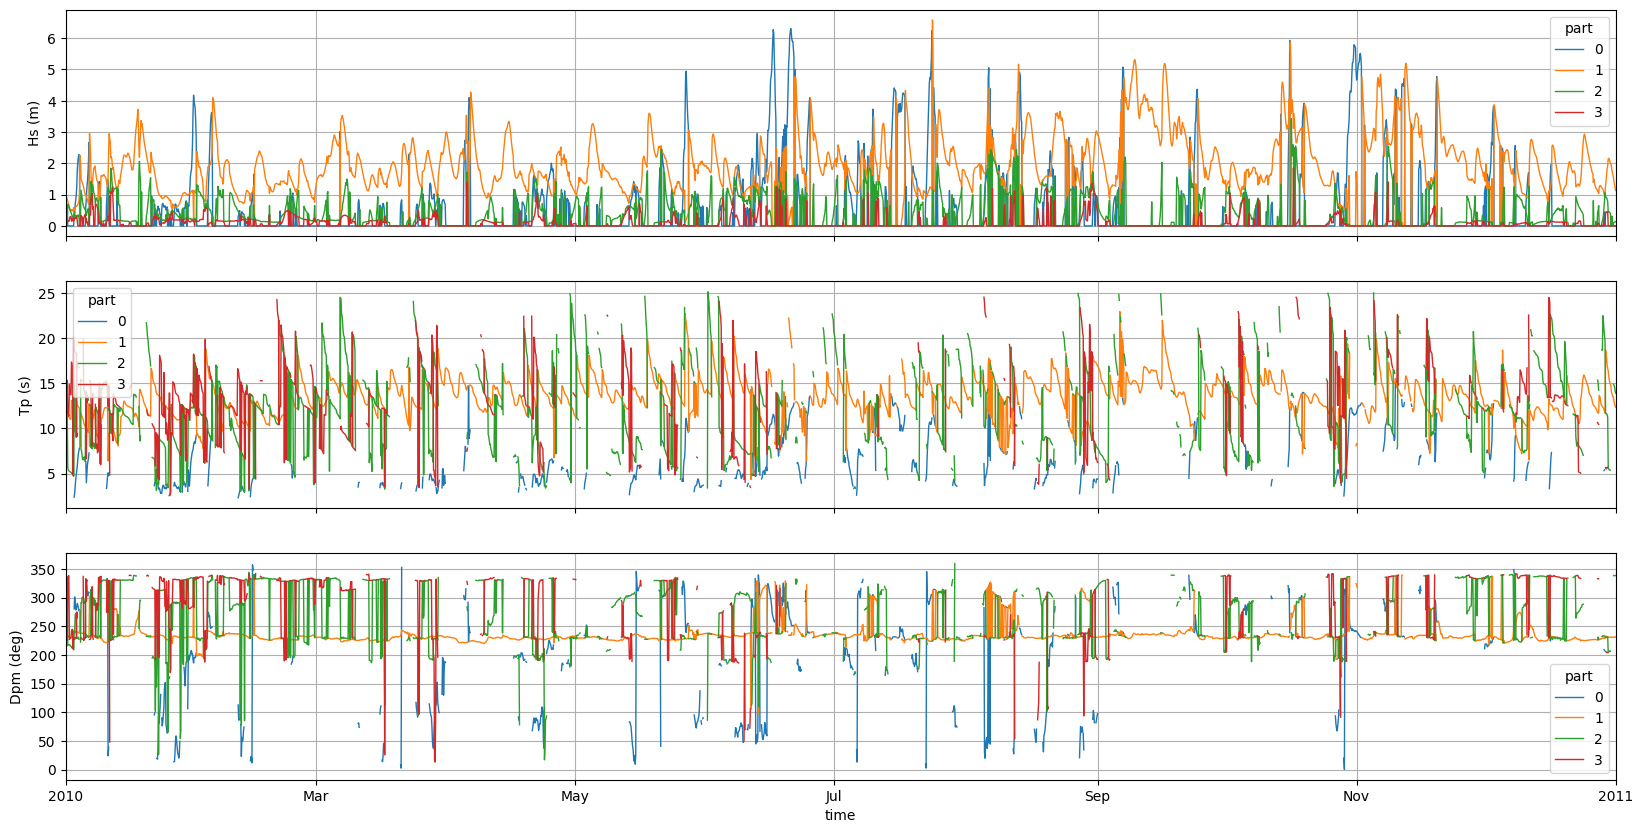

In [23]:
# Plotting
fig, axs = plt.subplots(3, 1, figsize=(20, 10))

t0, t1 = dset_spectra.time.to_index()[[0, -1]]

# Calculate and plot Hs
ax = axs[0]
dspart.spec.hs().plot.line(ax=ax, x="time", linewidth=1.0)
ax.set_ylabel("Hs (m)")

# Calculate and plot Tp
ax = axs[1]
dspart.spec.tp().plot.line(ax=ax, x="time", linewidth=1.0)
ax.set_ylabel("Tp (s)")

# Calculate and plot Dpm
ax = axs[2]
dspart.spec.dpm().plot.line(ax=ax, x="time", linewidth=1.0)
ax.set_ylabel("Dpm (deg)")

for ind, ax in enumerate(axs):
    if ind < len(axs) - 1:
        ax.set_xticklabels("")
        ax.set_xlabel("")
    ax.grid()
    ax.set_xlim(t0, t1)

Scatter plot of the watershed partiton parameters

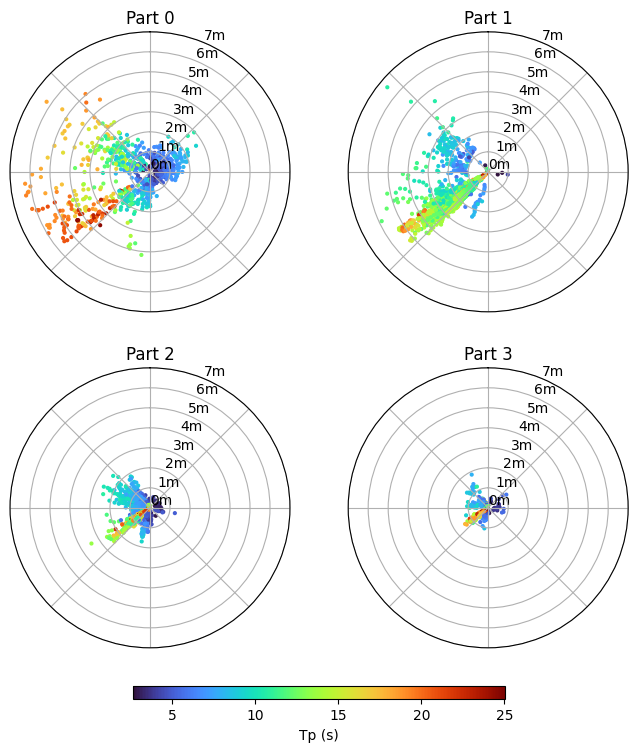

In [24]:
hs = dspart.spec.hs()
tp = dspart.spec.tp()
dpm = dspart.spec.dpm()
theta = np.radians(dpm)

fig, axs = plt.subplots(2, 2, figsize=(8, 10), subplot_kw={"projection": "polar"})

for ind, ax in enumerate(axs.flat):
    scatter = ax.scatter(
        x=theta.isel(part=ind),
        y=hs.isel(part=ind),
        c=tp.isel(part=ind),
        s=4,
        cmap="turbo",
    )
    ax.set_title(f"Part {ind}")
    ax.set_theta_direction("clockwise")
    ax.set_theta_zero_location("N")

    ax.set_rlim(0, 7)  
    ticks = np.arange(0, 7.1, 1)
    ax.set_rgrids(ticks, labels=[f"{f:.0f}m" for f in ticks])

    ax.set_xticklabels([])
    t = ax.set_thetagrids(np.arange(0, 360, 45))

cbar = fig.colorbar(
    scatter, ax=axs, orientation='horizontal', shrink=0.6, aspect=30, pad=0.05
)
cbar.set_label("Tp (s)")


## 4. Temporal Patterns

Here we analyse changes to wave spectral conditions at a representative location in the Southern Ocean just SW of New Zealand. Three 20-year periods are selected to represent the historical (1985-2005), mid-century (2040-2060), and late-century (2080-2100) periods. The SSP370 emission scenario is used to represent future conditions.

### 4.1. Query spectra

Query spectra at two locations on the West and East coast

### 4.1.1. Define location

Select a representative location within the Southern Ocean to carry out the analysis.

In [25]:
socean = Point(140, -55)

Plot the location on a map of the mean historical Hs from the gridstats dataset.

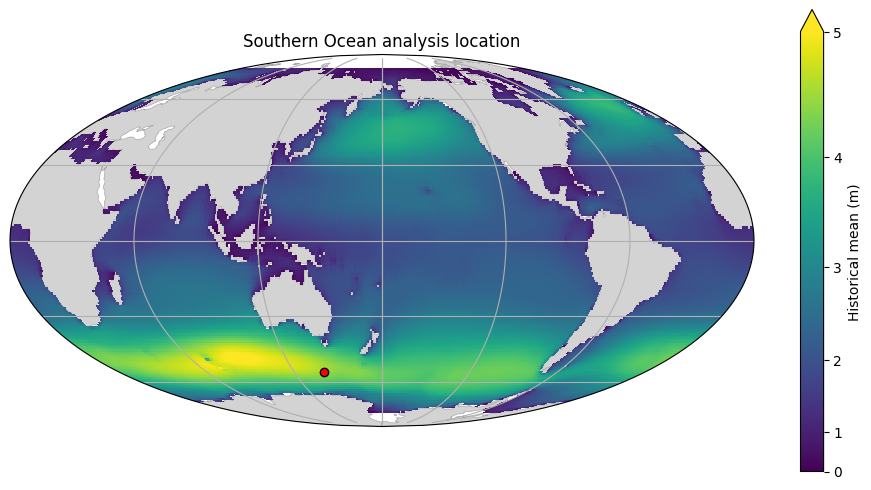

In [26]:
ds_gridstats = conn.query(
    datasource="oceanum_cmip6_ww3_global_ec_earth3_historical_r1i1p1f1_gridstats",
    variables=["hs_mean"],
)

projection = ccrs.Mollweide(central_longitude=180)
transform = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(12, 6), subplot_kw={"projection": projection})

ds_gridstats.hs_mean.plot(
    ax=ax,
    transform=transform,
    norm=PowerNorm(1.5, 0, 5),
    cbar_kwargs={"label": "Historical mean (m)"},
)
ax.plot(socean.x, socean.y, "or", markeredgecolor="black", transform=transform)
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="darkgray", linewidth=0.5)
ax.set_global()
ax.gridlines()
t = ax.set_title("Southern Ocean analysis location")

In [27]:
# Define the three time periods
periods = dict(
    hist=[datetime(1985, 1, 1, 0), datetime(2005, 1, 1, 0)],
    midc=[datetime(2040, 1, 1, 0), datetime(2060, 1, 1, 0)],
    latc=[datetime(2080, 1, 1, 0), datetime(2100, 1, 1, 0)]
)

#### 4.1.2. Query the historical spectra

In [28]:
dset_hist = query_timeseries(
    datasource="oceanum_cmip6_ww3_global_ec_earth3_historical_r1i1p1f1_spectra",
    points=[socean],
    t0=periods["hist"][0],
    t1=periods["hist"][1],
)
dset_hist

<xarray.Dataset> Size: 349MB
Dimensions:      (dir: 24, time: 58441, freq: 31)
Coordinates:
  * dir          (dir) float32 96B 270.0 255.0 240.0 225.0 ... 315.0 300.0 285.0
  * freq         (freq) float32 124B 0.037 0.0407 0.04477 ... 0.5869 0.6456
  * time         (time) datetime64[ns] 468kB 1985-01-01 ... 2005-01-01
Data variables:
    dpt          (time) float32 234kB 3.818e+03 3.818e+03 ... 3.818e+03
    efth         (time, freq, dir) float64 348MB 0.0 0.0 0.0 ... 5e-05 3e-05
    lat          float32 4B -56.0
    lon          float32 4B 140.0
    site         float64 8B 1.455e+03
    wdir         (time) float32 234kB 239.3 241.6 247.9 ... 347.5 350.9 344.9
    wspd         (time) float32 234kB 9.889 8.908 8.176 ... 13.59 14.37 13.59
    spatial_ref  int64 8B 0
Attributes: (12/19)
    altitude_resolution:    n/a
    area:                   Global 1 x 1 degree forced wit
    data_type:              OCO spectra 2D
    easternmost_longitude:  n/a
    field_type:             3-hourly
    format_version:         1.1
    ...                     ...
    start_date:             2014-01-01 00:00:00
    stop_date:              2015-01-01 00:00:00
    westernmost_longitude:  n/a
    xinterp_method:         nearest
    _coordinates:           {"d":"dir","f":"freq","t":"time","x":"lon","y":"l...
    _request_size:          349009896

#### 4.1.3. Query the mid-century spectra

In [29]:
dset_midc = query_timeseries(
    datasource="oceanum_cmip6_ww3_global_ec_earth3_ssp370_r1i1p1f1_spectra",
    points=[socean],
    t0=periods["midc"][0],
    t1=periods["midc"][1],
)
dset_midc

<xarray.Dataset> Size: 349MB
Dimensions:      (dir: 24, time: 58441, freq: 31)
Coordinates:
  * dir          (dir) float32 96B 270.0 255.0 240.0 225.0 ... 315.0 300.0 285.0
  * freq         (freq) float32 124B 0.037 0.0407 0.04477 ... 0.5869 0.6456
  * time         (time) datetime64[ns] 468kB 2040-01-01 ... 2060-01-01
Data variables:
    dpt          (time) float32 234kB 3.818e+03 3.818e+03 ... 3.818e+03
    efth         (time, freq, dir) float64 348MB 0.0 0.0 0.0 ... 5e-05 5e-05
    lat          float32 4B -56.0
    lon          float32 4B 140.0
    site         float64 8B 1.455e+03
    wdir         (time) float32 234kB 2.326 9.265 351.3 ... 333.3 313.5 319.7
    wspd         (time) float32 234kB 5.141 5.658 4.946 ... 7.813 7.859 7.486
    spatial_ref  int64 8B 0
Attributes: (12/19)
    altitude_resolution:    n/a
    area:                   Global 1 x 1 degree forced wit
    data_type:              OCO spectra 2D
    easternmost_longitude:  n/a
    field_type:             3-hourly
    format_version:         1.1
    ...                     ...
    start_date:             2099-01-01 00:00:00
    stop_date:              2100-01-01 00:00:00
    westernmost_longitude:  n/a
    xinterp_method:         nearest
    _coordinates:           {"d":"dir","f":"freq","t":"time","x":"lon","y":"l...
    _request_size:          349009896

#### 4.1.4. Query the late-century spectra

In [30]:
dset_latc = query_timeseries(
    datasource="oceanum_cmip6_ww3_global_ec_earth3_ssp370_r1i1p1f1_spectra",
    points=[socean],
    t0=periods["latc"][0],
    t1=periods["latc"][1],
)
dset_latc

<xarray.Dataset> Size: 349MB
Dimensions:      (dir: 24, time: 58441, freq: 31)
Coordinates:
  * dir          (dir) float32 96B 270.0 255.0 240.0 225.0 ... 315.0 300.0 285.0
  * freq         (freq) float32 124B 0.037 0.0407 0.04477 ... 0.5869 0.6456
  * time         (time) datetime64[ns] 468kB 2080-01-01 ... 2100-01-01
Data variables:
    dpt          (time) float32 234kB 3.818e+03 3.818e+03 ... 3.818e+03
    efth         (time, freq, dir) float64 348MB 0.0 0.0 0.0 ... 2e-05 2e-05
    lat          float32 4B -56.0
    lon          float32 4B 140.0
    site         float64 8B 1.455e+03
    wdir         (time) float32 234kB 245.6 246.8 244.3 ... 289.9 252.5 230.5
    wspd         (time) float32 234kB 9.545 8.961 8.358 ... 6.531 4.723 5.005
    spatial_ref  int64 8B 0
Attributes: (12/19)
    altitude_resolution:    n/a
    area:                   Global 1 x 1 degree forced wit
    data_type:              OCO spectra 2D
    easternmost_longitude:  n/a
    field_type:             3-hourly
    format_version:         1.1
    ...                     ...
    start_date:             2099-01-01 00:00:00
    stop_date:              2100-01-01 00:00:00
    westernmost_longitude:  n/a
    xinterp_method:         nearest
    _coordinates:           {"d":"dir","f":"freq","t":"time","x":"lon","y":"l...
    _request_size:          349009896

### 4.2. Plot Southern Ocean spectra

#### 4.2.1. Calculate and plot the mean spectra for each period

In [31]:
# Calculate means for each period and merge into a single dataset for plotting 
dset = xr.concat(
    [
        dset_hist.mean(dim="time"),
        dset_midc.mean(dim="time"),
        dset_latc.mean(dim="time"),
    ],
    dim="period",
)
dset["period"] = ["hist", "midc", "latc"]

# Calculate and merge integrated parameters for the plot titles
dset = xr.merge([dset, dset.spec.stats(["hs", "tp", "dpm"])])
dset

<xarray.Dataset> Size: 18kB
Dimensions:      (period: 3, freq: 31, dir: 24)
Coordinates:
  * dir          (dir) float32 96B 270.0 255.0 240.0 225.0 ... 315.0 300.0 285.0
  * freq         (freq) float32 124B 0.037 0.0407 0.04477 ... 0.5869 0.6456
  * period       (period) <U4 48B 'hist' 'midc' 'latc'
Data variables:
    dpt          (period) float64 24B 3.82e+03 3.82e+03 3.82e+03
    efth         (period, freq, dir) float64 18kB 0.0003462 ... 4.57e-05
    lat          (period) float64 24B -56.0 -56.0 -56.0
    lon          (period) float64 24B 140.0 140.0 140.0
    site         (period) float64 24B 1.455e+03 1.455e+03 1.455e+03
    wdir         (period) float64 24B 251.3 256.2 263.5
    wspd         (period) float64 24B 10.52 10.94 11.26
    spatial_ref  (period) float64 24B 0.0 0.0 0.0
    hs           (period) float64 24B 4.705 4.935 5.016
    tp           (period) float32 12B dask.array<chunksize=(3,), meta=np.ndarray>
    dpm          (period) float32 12B dask.array<chunksize=(3,), meta=np.ndarray>

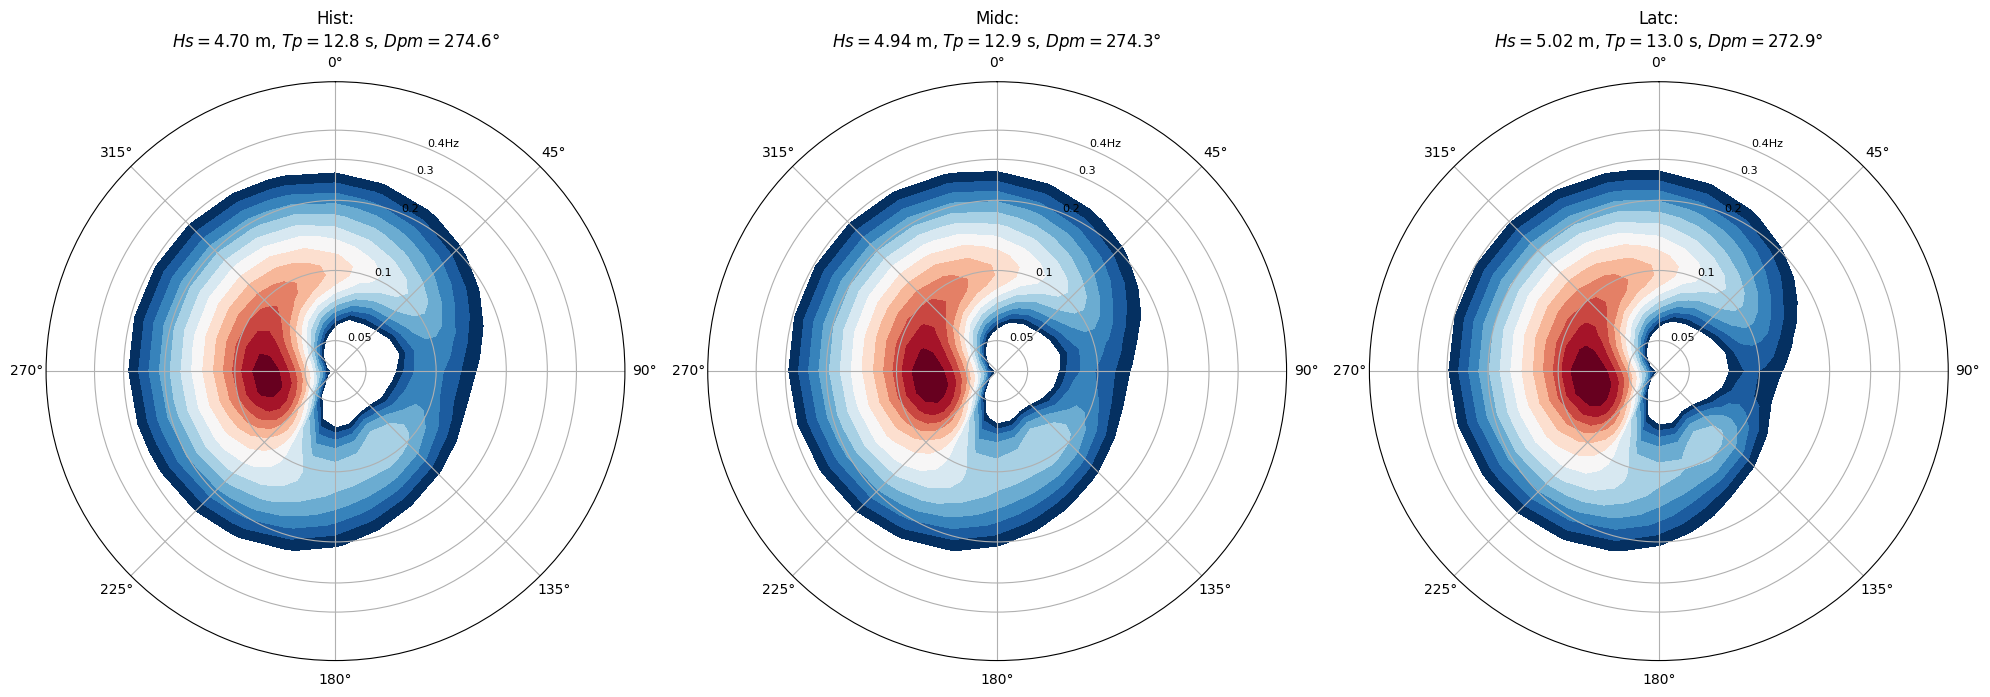

In [32]:
p = dset.spec.plot(col="period", figsize=(20, 8), add_colorbar=False)

for ind, ax in enumerate(p.axs.flat):
    name = dset.period.values[ind].title()
    hs = dset.hs.values[ind]
    tp = dset.tp.values[ind]
    dpm = dset.dpm.values[ind]
    ax.set_title(f"{name}:\n$Hs=${hs:.2f} m, $Tp=${tp:.1f} s, $Dpm=${dpm:.1f}°")

#### 4.2.2. Calculate and plot the 99th percentile of the wave spectra

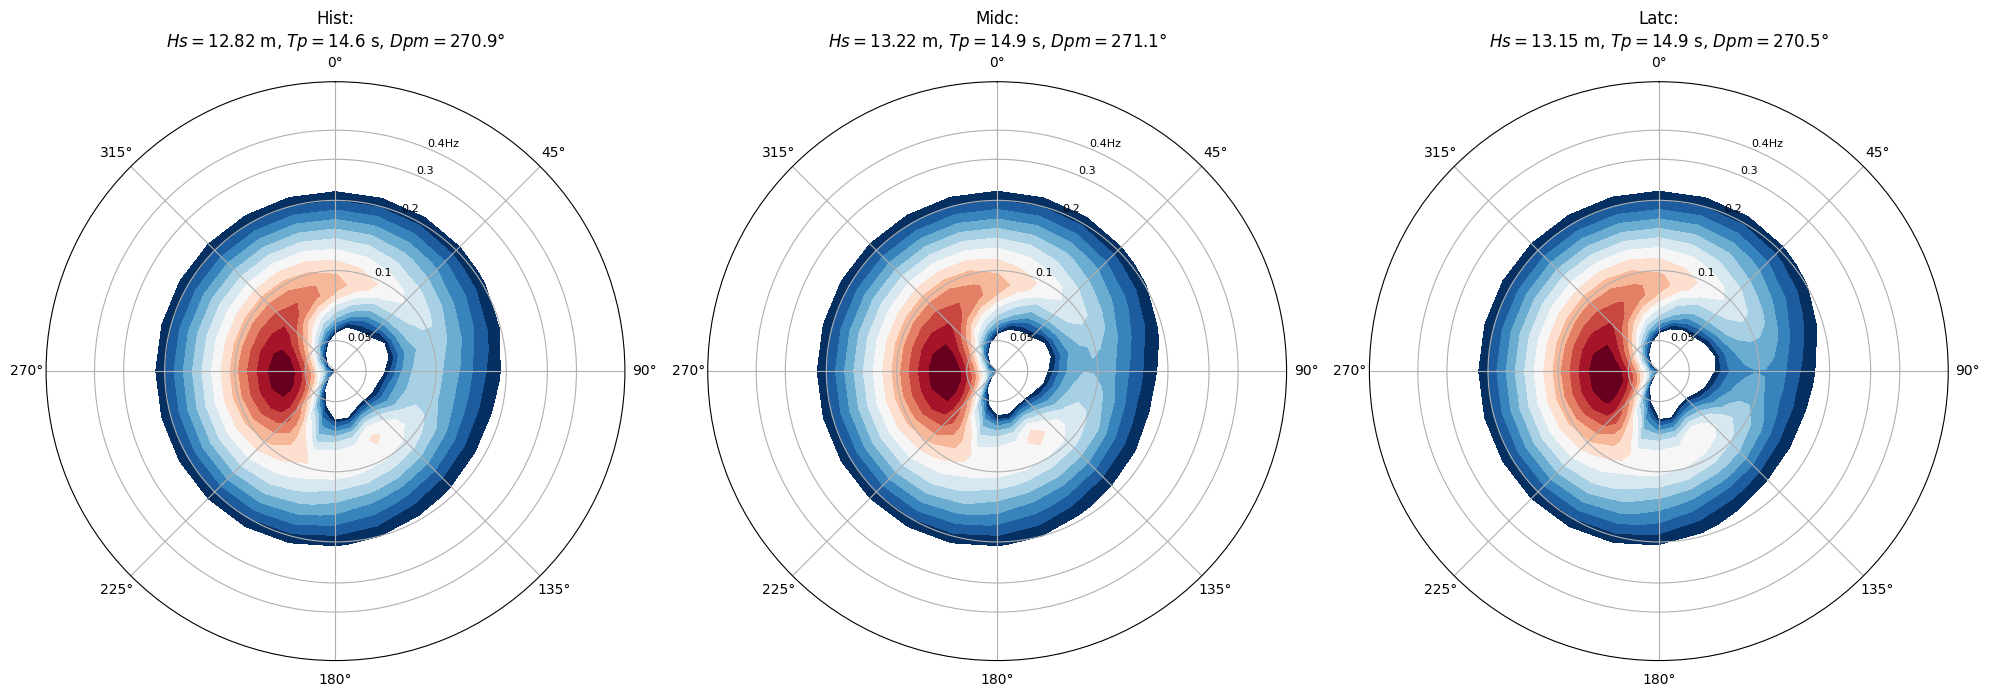

In [34]:
# Calculate means for each period and merge into a single dataset for plotting 
dset = xr.concat(
    [
        dset_hist.quantile(dim="time", q=0.99),
        dset_midc.quantile(dim="time", q=0.99),
        dset_latc.quantile(dim="time", q=0.99),
    ],
    dim="period",
)
dset["period"] = ["hist", "midc", "latc"]

# Calculate and merge integrated parameters for the plot titles
dset = xr.merge([dset, dset.spec.stats(["hs", "tp", "dpm"])])

# Plotting
p = dset.spec.plot(col="period", figsize=(20, 8), add_colorbar=False)

for ind, ax in enumerate(p.axs.flat):
    name = dset.period.values[ind].title()
    hs = dset.hs.values[ind]
    tp = dset.tp.values[ind]
    dpm = dset.dpm.values[ind]
    ax.set_title(f"{name}:\n$Hs=${hs:.2f} m, $Tp=${tp:.1f} s, $Dpm=${dpm:.1f}°")

#### 4.2.3. Seasonal mean historical

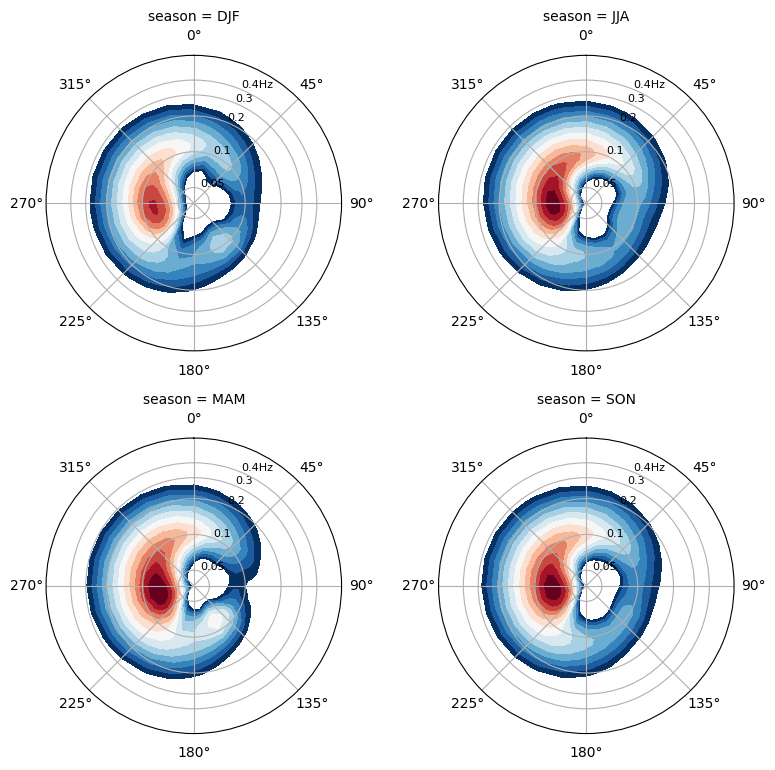

In [35]:
# Calculate the seasonal mean of the wave spectra
dset = dset_hist.groupby("time.season").mean()

# Plot the seasonal mean of the wave spectra
dset.spec.plot(col="season", col_wrap=2, add_colorbar=False, figsize=(8, 8))

#### 4.2.4. Seasonal mean mid century

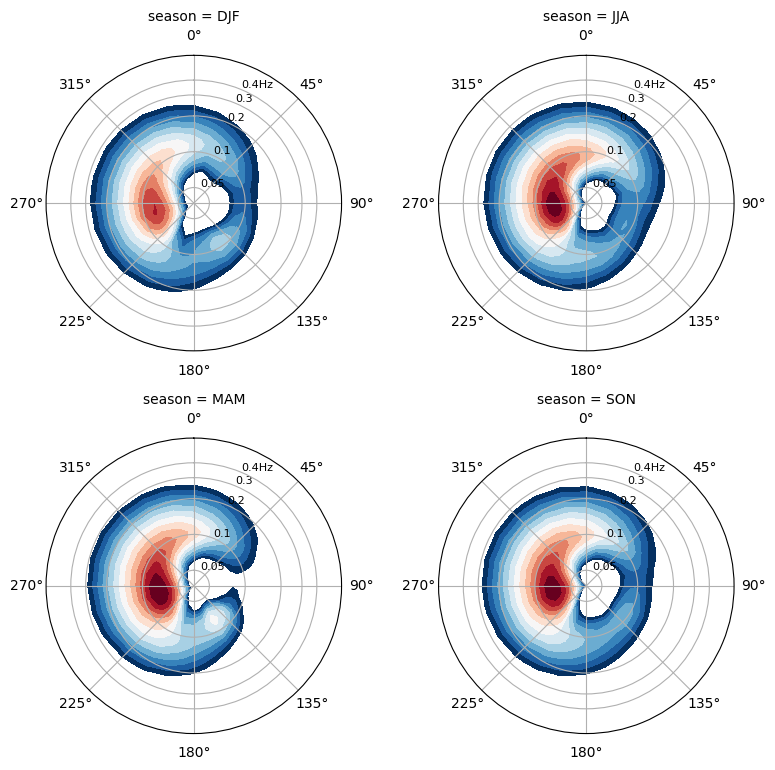

In [36]:
# Calculate the seasonal mean of the wave spectra
dset = dset_midc.groupby("time.season").mean()

# Plot the seasonal mean of the wave spectra
dset.spec.plot(col="season", col_wrap=2, add_colorbar=False, figsize=(8, 8))

#### 4.2.5. Seasonal mean late century

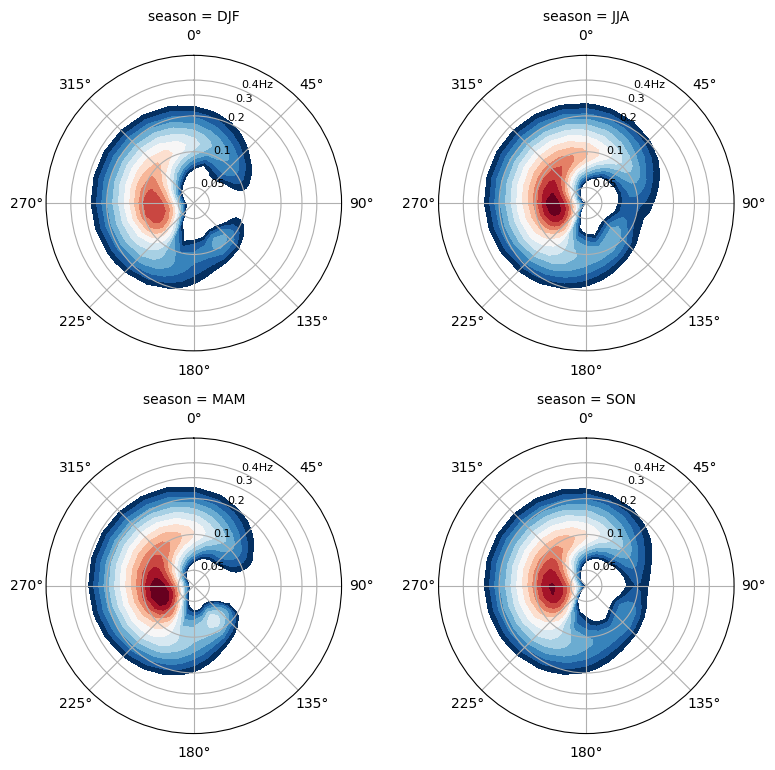

In [37]:
# Calculate the seasonal mean of the wave spectra
dset = dset_latc.groupby("time.season").mean()

# Plot the seasonal mean of the wave spectra
dset.spec.plot(col="season", col_wrap=2, add_colorbar=False, figsize=(8, 8))

## 5. Boundary generation

### 5.1. Define the boundary

#### 5.1.1. Generate the boundary bounding box

In [124]:
from shapely import box
import geopandas as gpd

bnd = gpd.GeoSeries(box(173.4, -39.6, 174.3, -39.0), crs="4326")
bnd

0    POLYGON ((174.3 -39.6, 174.3 -39, 173.4 -39, 1...
dtype: geometry

#### 5.1.2. Plot it with the New Zealand spectral points

<GeoAxes: title={'center': 'SWAN New Zealand spectral locations'}>

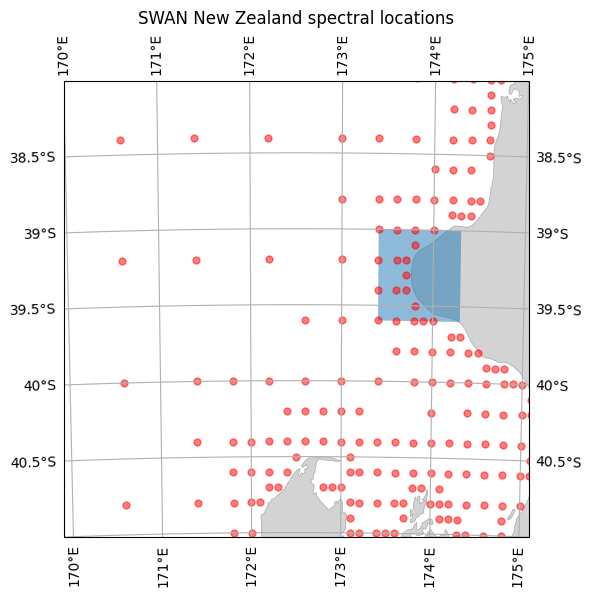

In [125]:
x0, y0, x1, y1 = 170, -41, 175, -38
projection = ccrs.TransverseMercator(central_longitude=(x0 + x1) / 2)
transform = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={"projection": projection})
ax.plot(coords_swan.lon, coords_swan.lat, "or", markersize=5, alpha=0.5, transform=transform)
ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="darkgray", linewidth=0.5)
ax.set_extent([x0, x1, y0, y1], crs=transform)
ax.gridlines(draw_labels=True)
t = ax.set_title("SWAN New Zealand spectral locations")
bnd.plot(ax=ax, transform=transform, alpha=0.5)

#### 5.1.3. Generate the boundary coordinates

##### 5.1.3.1. Query within a bufferend bounding box

Query a month of spectra for all the sites within a bounding box around the actual
domain of interest. The boundary data will be interpolated from these sites.



In [119]:
dset = conn.query(
    datasource="oceanum_cmip6_swan_nz_ec_earth3_ssp370_r1i1p1f1_spectra",
    timefilter={
        "type": "range",
        "times": ["2099-12-01T00", "2100-01-01T00"],
    },
    geofilter={
        "type": "bbox",
        "geom": [173.0, -39.8, 174.5, -38.8],
    },
)
dset

<xarray.Dataset> Size: 90MB
Dimensions:  (dir: 36, time: 249, site: 39, freq: 32)
Coordinates:
  * dir      (dir) float32 144B 265.0 255.0 245.0 235.0 ... 295.0 285.0 275.0
  * freq     (freq) float32 128B 0.037 0.0407 0.04477 ... 0.5869 0.6456 0.7102
    lat      (site) float32 156B -39.6 -39.2 -38.8 -39.6 ... -38.8 -39.8 -38.8
    lon      (site) float32 156B 173.0 173.0 173.0 173.4 ... 174.4 174.5 174.5
  * site     (site) int64 312B 562 563 564 629 630 631 ... 815 816 817 832 833
  * time     (time) datetime64[ns] 2kB 2099-12-01 ... 2100-01-01
Data variables:
    dpt      (time, site) float32 39kB 133.8 130.0 129.0 ... 39.77 9.714 24.01
    efth     (time, site, freq, dir) float64 89MB 0.0 0.0 0.0 ... 1e-05 1e-05
    wdir     (time, site) float32 39kB 325.7 334.3 328.5 ... 284.4 190.2 289.5
    wspd     (time, site) float32 39kB 6.501 6.713 6.368 ... 4.863 2.514 5.36
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    cycle:                   2015-01-01T00:00:00
    model:                   41.31A
    project:                 New Zealand 5km
    run:                     nz
    _coordinates:            {"d":"dir","f":"freq","t":"time","x":"lon","y":"...
    _request_size:           89615996

##### 5.1.3.2. Define the boundary locations

Create points around the boundary with a regular spacing

In [198]:
# Define the resolution
spacing = 0.1

# Convert polygon to boundary (LineString)
boundary = bnd.boundary.iloc[0]

# Interpolate along the boundary
distances = np.arange(0, boundary.length, spacing)
points = gpd.GeoSeries([boundary.interpolate(d) for d in distances], crs="4326")
points.head()

0    POINT (174.3 -39.6)
1    POINT (174.3 -39.5)
2    POINT (174.3 -39.4)
3    POINT (174.3 -39.3)
4    POINT (174.3 -39.2)
dtype: geometry

##### 5.1.3.3. Plot the boundary and wave spectra locations

Plot the locations of the points queried with the boundary and domain to visualise.

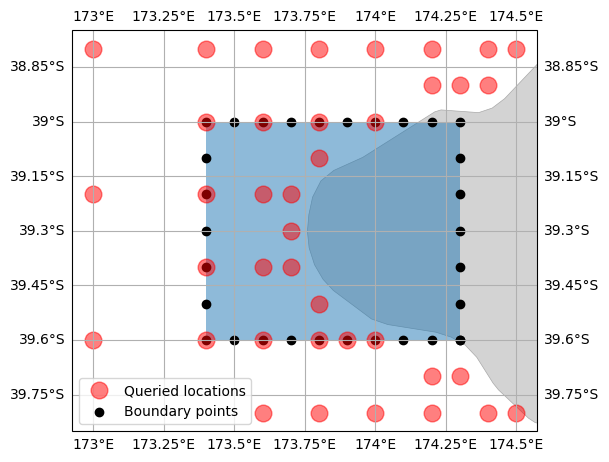

In [136]:
projection = ccrs.PlateCarree()#(central_longitude=(x0 + x1) / 2)
transform = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={"projection": projection})

ax.plot(dset.lon, dset.lat, "or", markersize=12, alpha=0.5, transform=transform, label="Queried locations")
bnd.plot(ax=ax, transform=transform, alpha=0.5, label="Domain")
points.plot(ax=ax, transform=transform, color="k", alpha=1.0, label="Boundary points")

ax.add_feature(cfeature.LAND, facecolor="lightgray", edgecolor="darkgray", linewidth=0.5)
ax.gridlines(draw_labels=True)
ax.legend()

##### 5.1.3.4. Interpolate spectra onto the boundary

Use the [wavespectra](https://wavespectra.readthedocs.io/en/latest/) library to
interpolate the spectra onto the boundary using a inverse distance weighting technique.

Interpolation from Datamesh will be supported soon!


In [189]:
lons = points.explode().x.values
lats = points.explode().y.values

# Tolerance controls the maximum distance from interpolated locations for IDW point selection
dset_bnd = dset.spec.sel(lons=lons, lats=lats, method="idw", tolerance=0.2)
dset_bnd

<xarray.Dataset> Size: 71MB
Dimensions:  (time: 249, site: 31, freq: 32, dir: 36)
Coordinates:
  * dir      (dir) float32 144B 265.0 255.0 245.0 235.0 ... 295.0 285.0 275.0
  * freq     (freq) float32 128B 0.037 0.0407 0.04477 ... 0.5869 0.6456 0.7102
  * time     (time) datetime64[ns] 2kB 2099-12-01 ... 2100-01-01
  * site     (site) int64 248B 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29 30
Data variables:
    dpt      (time, site) float32 31kB 18.48 nan nan nan ... 20.62 19.41 18.48
    efth     (time, site, freq, dir) float64 71MB 0.0 0.0 ... 2e-05 1.586e-05
    wdir     (time, site) float32 31kB 294.1 nan nan nan ... 240.7 234.9 231.1
    wspd     (time, site) float32 31kB 7.477 nan nan nan ... 3.328 2.932 2.709
    lon      (site) float64 248B 174.3 174.3 174.3 174.3 ... 174.1 174.2 174.3
    lat      (site) float64 248B -39.6 -39.5 -39.4 -39.3 ... -39.6 -39.6 -39.6
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    cycle:                   2015-01-01T00:00:00
    model:                   41.31A
    project:                 New Zealand 5km
    run:                     nz
    _coordinates:            {"d":"dir","f":"freq","t":"time","x":"lon","y":"...
    _request_size:           89615996

##### 5.1.3.5. Plot stats from interpolated point

The dataset **dset_bnd** is the boundary dataset ready to be used for analysis. Let's calculate
and plot integrated wave parameters for the first timestamp for sanity checking.

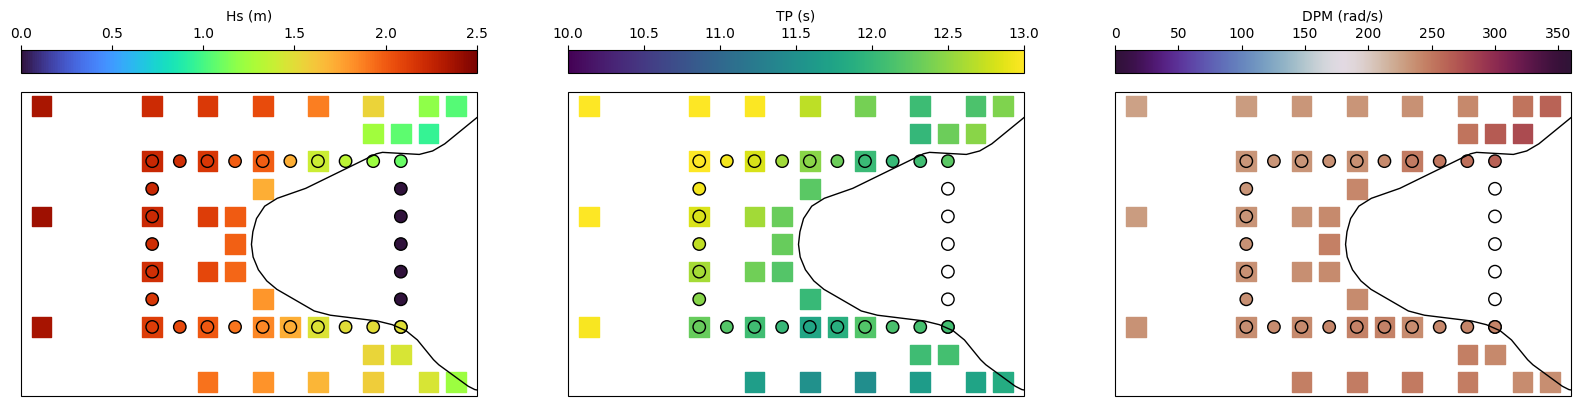

In [187]:
hs = dset_bnd.isel(time=0).spec.hs().fillna(0.0)
tp = dset_bnd.isel(time=0).spec.tp()
dpm = dset_bnd.isel(time=0).spec.dpm()

projection = transform = ccrs.PlateCarree()
fig, axs = plt.subplots(1, 3, figsize=(20, 5), subplot_kw={'projection': projection})

ax = axs[0]
kwargs = dict(cmap="turbo", vmin=0, vmax=2.5, transform=transform)
# Plot Original points from Datamesh
ax.scatter(dset.lon, dset.lat, marker="s", s=200, c=dset.isel(time=0).spec.hs(), **kwargs)
# Plot Interpolated points from wavespectra
p = ax.scatter(dset_bnd.lon, dset_bnd.lat, c=hs, s=80, edgecolors="k", **kwargs)
plt.colorbar(p, location="top", label="Hs (m)")

ax = axs[1]
kwargs = dict(vmin=10, vmax=13, transform=transform, cmap="viridis")
# Plot Original points from Datamesh
ax.scatter(dset.lon, dset.lat, marker="s", s=200, c=dset.isel(time=0).spec.tp(), **kwargs)
# Plot Interpolated points from wavespectra
p = ax.scatter(dset_bnd.lon, dset_bnd.lat, c=tp, s=80, edgecolors="k", **kwargs)
plt.colorbar(p, location="top", label="TP (s)")

ax = axs[2]
kwargs = dict(vmin=0, vmax=360, transform=transform, cmap="twilight_shifted")
# Plot Original points from Datamesh
ax.scatter(dset.lon, dset.lat, marker="s", s=200, c=dset.isel(time=0).spec.dpm(), **kwargs)
# Plot Interpolated points from wavespectra
p = ax.scatter(dset_bnd.lon, dset_bnd.lat, c=dpm, s=80, edgecolors="k", **kwargs)
plt.colorbar(p, location="top", label="DPM (rad/s)")

for ax in axs:
    ax.coastlines(resolution="10m")

##### 5.1.3.6. Save the boundary spectra

The boundary spectra can be easily written in different formats using wavespectra or xarray.
In this example, we write SWAN ASCII files which are ready to be used to run SWAN.

In [192]:
# Use the initial time to name the file
time = dset_bnd.time.to_index()[0]
filename = f"swan_boundary_{time:%Y%m%dT%H}.swn"
print(filename)

# Save to SWAN ASCII
dset_bnd.spec.to_swan(filename)

swan_boundary_20991201T00.swn


In [194]:
!head -n 15 swan_boundary_20991201T00.swn

SWAN   1                                Swan standard spectral file
$   Created by wavespectra
$   
TIME                                    time-dependent data
     1                                  time coding option
LONLAT                                  locations in spherical coordinates
    31                                  number of locations
  174.300000  -39.600000
  174.300000  -39.500000
  174.300000  -39.400000
  174.300000  -39.300000
  174.300000  -39.200000
  174.300000  -39.100000
  174.300000  -39.000000
  174.200000  -39.000000


Wavespectra can be used to read this file in if needed.

In [195]:
from wavespectra import read_swan

dset_saved = read_swan("swan_boundary_20991201T00.swn")
dset_saved

<xarray.Dataset> Size: 71MB
Dimensions:  (time: 249, site: 31, freq: 32, dir: 36)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2099-12-01 ... 2100-01-01
  * site     (site) int64 248B 1 2 3 4 5 6 7 8 9 ... 23 24 25 26 27 28 29 30 31
  * freq     (freq) float64 256B 0.037 0.0407 0.04477 ... 0.5869 0.6456 0.7102
  * dir      (dir) float64 288B 5.0 15.0 25.0 35.0 ... 325.0 335.0 345.0 355.0
Data variables:
    efth     (time, site, freq, dir) float64 71MB 0.0 0.0 ... 9.941e-06
    lat      (site) float64 248B -39.6 -39.5 -39.4 -39.3 ... -39.6 -39.6 -39.6
    lon      (site) float64 248B 174.3 174.3 174.3 174.3 ... 174.1 174.2 174.3

To finalise, let's wrap the boundary generation from Datamesh into a function so it
can be easily used to generate boundaries for any time period and model.

In [201]:
def generate_boundary(
    datasource: str,
    t0: str | datetime,
    t1: str | datetime,
    x0: float,
    y0: float,
    x1: float,
    y1: float,
    buffer: float,
    tolerance: float,
) -> xr.Dataset:
    """Generate boundary spectra from Datamesh.

    Parameters
    ----------
    datasource : str
        Name of the datasource to query.
    t0 : str | datetime
        Start time of the query.
    t1 : str | datetime
        End time of the query.
    x0 : float
        Minimum longitude of the bounding box.
    y0 : float
        Minimum latitude of the bounding box.
    x1 : float
        Maximum longitude of the bounding box.
    y1 : float
        Maximum latitude of the bounding box.
    buffer : float
        Buffer distance around the bounding box.
    tolerance : float
        Tolerance for the IDW interpolation.

    Returns
    -------
    xr.Dataset
        Dataset containing the boundary spectra.
    
    Note
    ----
    This process could potentially query several sites depending on the area and time
    length. Ensure small time chunks (e.g., monthly) to avoid memory issues.

    """
    # Quary the spectra from Datamesh
    bbox = [x0 - buffer, y0 - buffer, x1 + buffer, y1 + buffer]
    dset = conn.query(
        datasource=datasource,
        timefilter={"type": "range", "times": [t0, t1]},
        geofilter={"type": "bbox", "geom": bbox},
    )

    # Define the boundary locations
    spacing = 0.1
    boundary = bnd.boundary.iloc[0]
    distances = np.arange(0, boundary.length, spacing)
    points = gpd.GeoSeries([boundary.interpolate(d) for d in distances], crs="4326")
    
    # Interpolate the spectra at the boundary locations
    lons = points.explode().x.values
    lats = points.explode().y.values
    dset_bnd = dset.spec.sel(lons=lons, lats=lats, method="idw", tolerance=tolerance)

    return dset_bnd

In [202]:
kwargs = dict(
    t0="2099-12-01T00:00:00",
    t1="2100-01-01T00:00:00",
    x0=173.4,
    y0=-39.6,
    x1=174.3,
    y1=-39.0,
    buffer=0.3,
    tolerance=0.2,
)

In [203]:
dset_bnd_ssp245 = generate_boundary(
    datasource="oceanum_cmip6_swan_nz_ec_earth3_ssp245_r1i1p1f1_spectra", **kwargs
)
dset_bnd_ssp245

<xarray.Dataset> Size: 71MB
Dimensions:  (time: 249, site: 31, freq: 32, dir: 36)
Coordinates:
  * dir      (dir) float32 144B 265.0 255.0 245.0 235.0 ... 295.0 285.0 275.0
  * freq     (freq) float32 128B 0.037 0.0407 0.04477 ... 0.5869 0.6456 0.7102
  * time     (time) datetime64[ns] 2kB 2099-12-01 ... 2100-01-01
  * site     (site) int64 248B 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29 30
Data variables:
    dpt      (time, site) float32 31kB 18.48 nan nan nan ... 20.62 19.41 18.48
    efth     (time, site, freq, dir) float64 71MB 0.0003633 0.001072 ... 1e-05
    wdir     (time, site) float32 31kB 320.3 nan nan nan ... 341.2 347.6 352.2
    wspd     (time, site) float32 31kB 7.982 nan nan nan ... 6.572 6.781 7.008
    lon      (site) float64 248B 174.3 174.3 174.3 174.3 ... 174.1 174.2 174.3
    lat      (site) float64 248B -39.6 -39.5 -39.4 -39.3 ... -39.6 -39.6 -39.6
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    cycle:                   2015-01-01T00:00:00
    model:                   41.31A
    project:                 New Zealand 5km
    run:                     nz
    _coordinates:            {"d":"dir","f":"freq","t":"time","x":"lon","y":"...
    _request_size:           85020420

In [204]:
dset_bnd_ssp370 = generate_boundary(
    datasource="oceanum_cmip6_swan_nz_ec_earth3_ssp370_r1i1p1f1_spectra", **kwargs
)
dset_bnd_ssp370

<xarray.Dataset> Size: 71MB
Dimensions:  (time: 249, site: 31, freq: 32, dir: 36)
Coordinates:
  * dir      (dir) float32 144B 265.0 255.0 245.0 235.0 ... 295.0 285.0 275.0
  * freq     (freq) float32 128B 0.037 0.0407 0.04477 ... 0.5869 0.6456 0.7102
  * time     (time) datetime64[ns] 2kB 2099-12-01 ... 2100-01-01
  * site     (site) int64 248B 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29 30
Data variables:
    dpt      (time, site) float32 31kB 18.48 nan nan nan ... 20.62 19.41 18.48
    efth     (time, site, freq, dir) float64 71MB 0.0 0.0 ... 2e-05 1.586e-05
    wdir     (time, site) float32 31kB 294.1 nan nan nan ... 240.7 234.9 231.1
    wspd     (time, site) float32 31kB 7.477 nan nan nan ... 3.328 2.932 2.709
    lon      (site) float64 248B 174.3 174.3 174.3 174.3 ... 174.1 174.2 174.3
    lat      (site) float64 248B -39.6 -39.5 -39.4 -39.3 ... -39.6 -39.6 -39.6
Attributes:
    Conventions:             CF-1.5
    Directional_convention:  nautical
    History:                 Created with agioncmd version 1.5
    Institution:             Oceanum Ltd
    cycle:                   2015-01-01T00:00:00
    model:                   41.31A
    project:                 New Zealand 5km
    run:                     nz
    _coordinates:            {"d":"dir","f":"freq","t":"time","x":"lon","y":"...
    _request_size:           85020420

Calculate and plot Hs from one of the boundary points to check

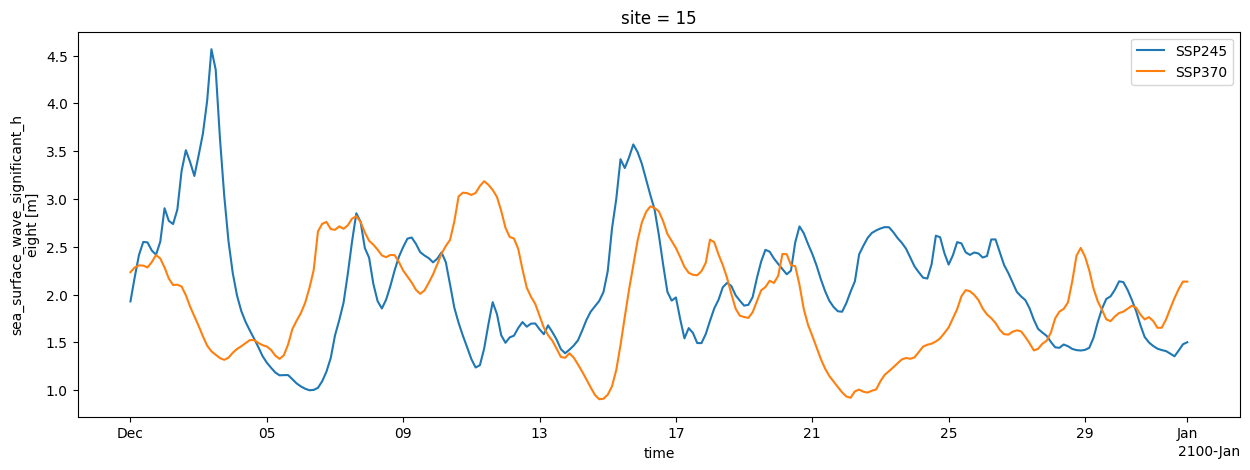

In [214]:
dset_bnd_ssp245.isel(site=15).spec.hs().plot(figsize=(15, 5), label="SSP245")
dset_bnd_ssp370.isel(site=15).spec.hs().plot(label="SSP370")
plt.legend();